In this notebook I'll make an attempt to anser the following question

# How can we improve the CV estimation of a metric when the train and the test data distributions are not the same?

In many cases a metric can be tought as an expected value over the joint distribution of $\large X, Y$, indicated by $\large P(X, Y)$

$\large M = \int m(x, y) dP(x, y)$

If we have a finite sample from $\large P(X, Y)$ indicated as $\large D = \{x_i, y_i\}_{i=1}^N$, we can approximate $\large M$ using the **Monte Carlo method**

$\large \hat{M}^{D}_{MC} = \frac{1}{N} \sum_{i=1}^N m(x_i, y_i)$

# The nail: train and test data distributions are not the same

i.e. $\large P_{train}(X, Y) \neq P_{test}(X, Y)$

Sadly enough the train and the test data distributions are not always the same (thanks Kaggle), so using held out training data can produce a biased estimation of the metric on the test distribution.

Can we do something about it? **Yes!**

# The hammer 🔨: importance sampling

We can use a techinque called **importance sampling** to adjust the Monte Carlo estimation with a correction factor given by the density ratio between the two distributions

$\large \hat{M}_{IS}^{test} = \frac{1}{N} \sum_{i=1}^N m(x_i, y_i) \frac{p_{test}(x_i, y_i)}{p_{train}(x_i, y_i)}$

where $\large (x_i, y_i)$ are sampled from $\large P_{train}(X, Y)$
 
If $\large P_{train}(X, Y) > 0$ almost everywhere $\large P_{test}(X, Y) > 0$ this estimator should be unbiased. In simpler terms, we need to have training examples from all over the test distribution to make a correct estimation.

But estimating a joint distribution is really hard, especially for non-tabular data... and it is impossible for the test set since we don't have the target variable 😅

## Hypotesys: the conditional distributions of the target variable are the same

We suppose that, given a point $\large x$, the conditional distribution of $\large y$ is the same for training and test data, i.e.

$\large P_{train}(Y|X) = P_{test}(Y|X)$

Then, using the **chain rule**, we can rewrite the Monte Carlo importance sampling formula as

$\large \hat{M}_{IS}^{test} = \frac{1}{N} \sum_{i=1}^N m(x_i, y_i) \frac{p_{test}(x_i)}{p_{train}(x_i)}$

Then all we have to do is to estimate the ratio of densities for $\large x$, much easier 😉

We can ironically call this correction factor '*testiness*', since it indicates how much an observation is useful to estimate the real value of the metric on the test distribution and how much more likely it is to be sampled from the test distribution rather then the train one. 

## Estimating the density ratio

We can train a learner $\large L$ to predict wheter a point $\large x$ is from the train or the test distribution

Then,  appling the **Bayes theorem** on $\mathbb{P}(Test|x)$, we can prove that

$\Large \frac{\mathbb{P}(x|Test)}{\mathbb{P}(x|Train)} = \frac{\mathbb{P}(Test|x)}{\mathbb{P}(Train|x)} \frac{\mathbb{P}(Train)}{\mathbb{P}(Test)}$

Using the trained learner $\large L$ to estimate $\large \mathbb{P}(Test|x) \approx L(x)$, we obtain

$\Large \frac{\mathbb{P}(x|Test)}{\mathbb{P}(x|Train)} \approx \frac{L(x)}{1 - L(x)} \frac{ \mathbb{P}(Train)}{\mathbb{P}(Test)}$

## Final result

Replacing the previous expression on the importance sampling formula we obtain

$\large \hat{M}_{L}^{test} = \frac{1}{N} \sum_{i=1}^N m(x_i, y_i) \frac{L(x_i) }{1 - L(x_i)} \frac{\mathbb{P}(Train)}{\mathbb{P}(Test)}$

where $\large (x_i, y_i)$ are sampled from the train distribution

# Application to this competition


I'll try to use the described technique to improve the CV estimation done in this nice [notebook](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords). The CV AUC is equal to about 0.904, but the LB AUC is equal to 0.9454. This gap is quite big and confusing.

The AUC can be represented as a double integral multiplied by a constant

$AUC = C \int \int \mathbb{1}[pred(x_0) < pred(x_1)] \ dp(x_0) \ dp(x_1)$

so the previous resoning can be similarly applied.

Is important to note that, as pointed [here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/168028), there are regions of the space that contain no train images but test ones, so the importance sampling estimate is still biased, but should be more accurate than the CV one.

To avoid overfitting the '*testiness*' will be estimated on the hold out data with repeated k-fold splits, using calibrated XGBoost classifiers.

Then, we can simply pass the '*testiness*' as '*sample_weight*' of the chosen sklearn metric (in this case AUC)

### Data reading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn import metrics, datasets, model_selection, linear_model, calibration
import xgboost, lightgbm
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

In [2]:
AUTO = tf.data.experimental.AUTOTUNE

def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    meta = tf.cast(tf.stack([example['sex'], example['age_approx']], 0), tf.float32)
    return example['image'], meta, example['image_name']

 
def prepare_image(img, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img


def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [3]:
train_files = tf.io.gfile.glob("../input/melanoma-256x256/train*.tfrec")
test_files = tf.io.gfile.glob("../input/melanoma-256x256/test*.tfrec")

In [4]:
oof = pd.read_csv("../input/triple-stratified-kfold-with-tfrecords/oof.csv") # the kernel out of fold prediction
base_train_data = pd.read_csv("../input/melanoma-256x256/train.csv")

Since we use XGBoost to estimate the '*testiness*', we need to preprocess the images.

We will use metadata (age and sex) and a few statistics of the images
* average and standard deviation
* channel-wise average and standard deviation

The target of our classification task will simply be $0$ for images from the train data and $1$ for the ones from the test set.

In [5]:
ds = tf.data.TFRecordDataset(train_files).map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda i, m, n: (prepare_image(i), m, n), num_parallel_calls=AUTO)
ds = ds.batch(128)
ds = ds.map(lambda i, m, n: (K.concatenate([m, K.reshape(K.mean(i, [1, 2, 3]), [-1, 1]), K.mean(i, [1, 2]), K.std(i, [1, 2])], axis=1), n), num_parallel_calls=AUTO)
ds = ds.prefetch(AUTO)
data_train = np.array([i for i, n in tqdm(ds.unbatch())])
name_train = np.array([n.numpy().decode('utf-8') for i, n in tqdm(ds.unbatch())])

ds = tf.data.TFRecordDataset(test_files).map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda i, m, n: (prepare_image(i), m, n), num_parallel_calls=AUTO)
ds = ds.batch(128)
ds = ds.map(lambda i, m, n: (K.concatenate([m, K.reshape(K.mean(i, [1, 2, 3]), [-1, 1]), K.mean(i, [1, 2]), K.std(i, [1, 2])]), n), num_parallel_calls=AUTO)
ds = ds.prefetch(AUTO)
data_test = np.array([i for i, n in tqdm(ds.unbatch())])
name_test = np.array([n.numpy().decode('utf-8') for i, n in tqdm(ds.unbatch())])

32692it [00:46, 696.63it/s]
32692it [00:48, 672.77it/s]
10982it [00:27, 398.02it/s]
10982it [00:16, 685.88it/s]


In [6]:
y = np.concatenate([np.zeros(data_train.shape[0]), np.ones(data_test.shape[0])], 0)
x = np.concatenate([data_train, data_test])
name = np.concatenate([name_train, name_test])

### Minimal EDA

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


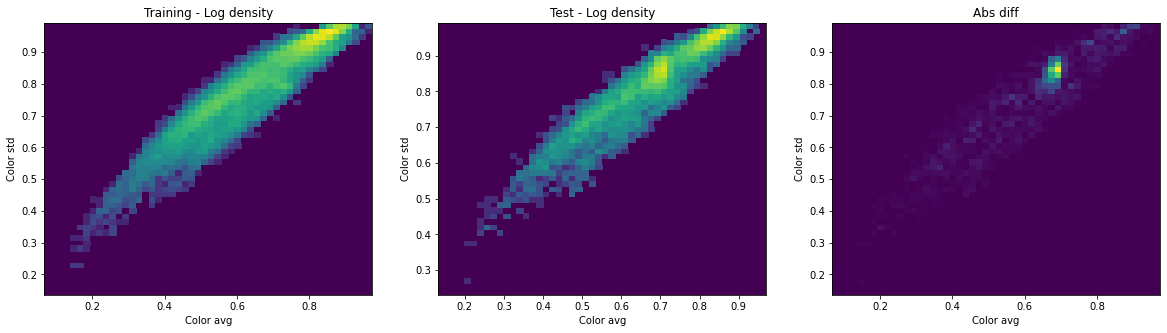

In [7]:
# train-test data distribution based on features (0: sex, 1: age, 2: img-avg, 3: img-std, 4..6: cw img-avg, 7..9: cw img-std)
i, j = 2, 3
bins = 50
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
c0, a0, b0, _ = plt.hist2d(x[y == 0, i], x[y == 0, j], bins=bins, density=True)
plt.pcolormesh(a0, b0, np.log(0 + c0).T);
plt.title("Training - Log density"); plt.xlabel("Color avg"); plt.ylabel("Color std")
plt.subplot(1, 3, 2)
plt.title("Test - Log density"); plt.xlabel("Color avg"); plt.ylabel("Color std")
c1, a1, b1, _ = plt.hist2d(x[y == 1, i], x[y == 1, j], bins=bins, density=True)
plt.pcolormesh(a1, b1, np.log(0 + c1).T);
plt.subplot(1, 3, 3)
plt.title("Abs diff"); plt.xlabel("Color avg"); plt.ylabel("Color std")
plt.pcolormesh(a0, b0, np.abs(c0 - c1).T);

We see that is sufficient to consider the average and the standard deviation of the images to see a clear difference between the train and the test distributions

### Example of training

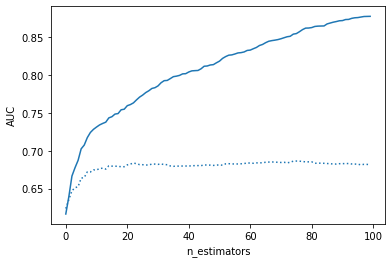

In [8]:
idxT, idxV = list(model_selection.KFold(5, shuffle=True).split(x, y))[0]
model = xgboost.XGBClassifier()
model.fit(x[idxT], y[idxT], eval_set=[(x[idxT], y[idxT]), (x[idxV], y[idxV])], eval_metric='auc', verbose=0)
plt.plot(model.evals_result_['validation_0']['auc'], color='tab:blue')
plt.plot(model.evals_result_['validation_1']['auc'], color='tab:blue', linestyle=":")
plt.xlabel('n_estimators')
plt.ylabel('AUC');

Here we see that it is difficult to predict wether an image is from training or test set, but it is clearly better than random guessing

### Calibration example

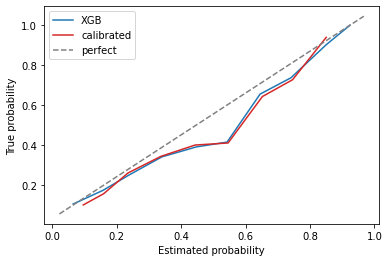

In [9]:
calibrated_model = calibration.CalibratedClassifierCV(model, cv='prefit')
xcT, xcV, ycT, ycV = model_selection.train_test_split(x[idxV], y[idxV])
calibrated_model.fit(xcT, ycT)
plt.plot(*calibration.calibration_curve(ycV, model.predict_proba(xcV)[:, 1], n_bins=10)[::-1], color='tab:blue', label='XGB')
plt.plot(*calibration.calibration_curve(ycV, calibrated_model.predict_proba(xcV)[:, 1], n_bins=10)[::-1], color='tab:red', label='calibrated')
plt.plot(plt.xlim(), plt.ylim(), color='gray', linestyle='--', label='perfect')
plt.xlabel('Estimated probability'); plt.ylabel('True probability');
plt.legend();

In this case the calibration seems not to be very useful, so we will skip it for this time

### Training

In [10]:
NREPS = 10
NFOLDS = 10
df_all = []
models = NFOLDS * [xgboost.XGBClassifier()]
for rep in range(NREPS):
    pid = base_train_data[['patient_id']].drop_duplicates().reset_index(drop=True)
    folds = list(model_selection.KFold(NFOLDS, shuffle=True).split(pid))
    df_rep = []
    for fold, (pidIdxT, pidIdxV) in enumerate(folds):
        pidT, pidV = pid.iloc[pidIdxT]['patient_id'], pid.iloc[pidIdxV]['patient_id']
        inT = base_train_data[base_train_data['patient_id'].isin(pidT)]['image_name']
        inV = base_train_data[base_train_data['patient_id'].isin(pidV)]['image_name']
        idxT = (pd.Series(name).isin(inT) | y == 1)
        idxV = (pd.Series(name).isin(inV))
        model = models[fold]
        model.fit(x[idxT], y[idxT])
        # calibration should go here
        pred = model.predict_proba(x[idxV])[:, 1]
        testiness = pred / (1 - pred) * np.mean(y[idxT] == 0) / np.mean(y[idxT] == 1)
        df = pd.DataFrame({'rep': rep, 'image_name': name[idxV], 'is_test': y[idxV], 'is_test_pred': pred, 'testiness': testiness})
        df_rep.append(df)
        pass
    df_rep = pd.concat(df_rep, axis=0)
    df = pd.merge(df_rep, oof, on='image_name')
    score = metrics.roc_auc_score(df.target, df.pred)
    corrected_score = metrics.roc_auc_score(df.target, df.pred, sample_weight=df.testiness)
    print("Rep%2d \t\tAUC  = %.6f \tcAUC = %.6f" % (rep, score, corrected_score))
    df_all.append(df_rep)
    pass
df_all = pd.concat(df_all, axis=0)
df = pd.merge(df_all, oof, on='image_name').groupby('image_name').mean()
score = metrics.roc_auc_score(df.target, df.pred)
corrected_score = metrics.roc_auc_score(df.target, df.pred, sample_weight=df.testiness)
print("Overall \tAUC  = %.6f \tcAUC = %.6f" % (score, corrected_score))

Rep 0 		AUC  = 0.903770 	cAUC = 0.912446
Rep 1 		AUC  = 0.903770 	cAUC = 0.911277
Rep 2 		AUC  = 0.903770 	cAUC = 0.912333
Rep 3 		AUC  = 0.903770 	cAUC = 0.918961
Rep 4 		AUC  = 0.903770 	cAUC = 0.916645
Rep 5 		AUC  = 0.903770 	cAUC = 0.917059
Rep 6 		AUC  = 0.903770 	cAUC = 0.911222
Rep 7 		AUC  = 0.903770 	cAUC = 0.915431
Rep 8 		AUC  = 0.903770 	cAUC = 0.921143
Rep 9 		AUC  = 0.903770 	cAUC = 0.913751
Overall 	AUC  = 0.903770 	cAUC = 0.915113


KL divergence pre  = 0.1563
KL divergence post = 0.1287
Difference = -17.6706%


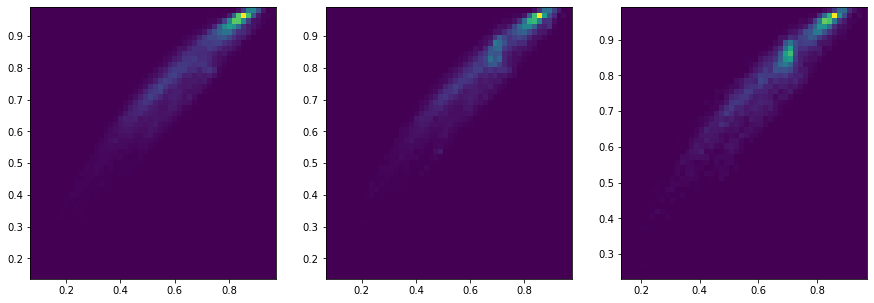

In [11]:
XX = pd.DataFrame({'y': y, 'x2': x[:, 2], 'x3': x[:, 3], 'image_name': name}).merge(df, on='image_name')
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
c0, a0, b0, _ = plt.hist2d(XX.x2[XX.y == 0], XX.x3[XX.y == 0], 50, density=True);
plt.subplot(1, 3, 2)
c1, a1, b1, _ = plt.hist2d(XX.x2[XX.y == 0], XX.x3[XX.y == 0], 50, density=True, weights=XX.testiness[XX.y == 0]);
plt.subplot(1, 3, 3)
ctest, atest, btest, _ = plt.hist2d(x[y == 1, 2], x[y == 1, 3], 50, density=True);
kl_pre = keras.losses.kld((c0 / c0.sum()).reshape(-1), (ctest / ctest.sum()).reshape(-1)).numpy()
kl_post = keras.losses.kld((c1 / c1.sum()).reshape(-1), (ctest / ctest.sum()).reshape(-1)).numpy()
print("KL divergence pre  = %.4f" % kl_pre)
print("KL divergence post = %.4f" % kl_post)
print("Difference = %.4f%%" % (100 * (kl_post - kl_pre) / kl_pre))

In [12]:
df_all[['image_name', 'testiness']].groupby('image_name').mean().to_csv("../working/testiness.csv")

# Next steps

* try a better model to estimate the '*testiness*' 😋
* is it possible to further improve the CV estimation in the case of different support for the two distributions?
* find a strategy to make calibration work
* try to use a similar correction directly inside the loss function of a model